In [19]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [1]:
import numpy as np
from kalman_bucy import kalman_bucy

def f_uI(t, uI, uII):
    sigma = 10
    return sigma * (uII[0] - uI)

def f_uII(t, uI, uII):
    rho, beta = 28, 8 / 3
    y, z = uII
    x = uI
    return np.array([
        -y - x * z + rho * x,
        x * y - beta * z
    ])

# Simulation parameters
T = 10
n = 1001
t_span = (0, T)
dt = (T - 0) / (n - 1)
t = np.linspace(*t_span, n)

# Generate dummy observed data uI (for example purposes)
true_uII = np.zeros((2, n))
true_uII[:, 0] = [1, 1]
uI = np.zeros(n)
uI[0] = 1

for i in range(1, n):
    true_uII[:, i] = true_uII[:, i-1] + dt * f_uII(t[i], uI[i-1], true_uII[:, i-1])
    uI[i] = uI[i-1] + dt * f_uI(t[i], uI[i-1], true_uII[:, i-1])

# Run Kalman-Bucy filter
results = kalman_bucy(
    d_uI=f_uI,
    d_uII=f_uII,
    t_span=t_span,
    uI=uI,
    uII_0=np.array([0.5, 0.5]),
    R0=np.eye(2),
    SigmaI=np.array([[0.1]]),
    SigmaII=np.array([[0.1], [0.1]]),
    dt=dt
)

# Access results
uII_est = results["uII"]
t_vals = results["t"]

# Optional: plot results
import matplotlib.pyplot as plt

plt.plot(t_vals, true_uII[0], label="True y")
plt.plot(t_vals, uII_est[0], '--', label="Estimated y")
plt.plot(t_vals, true_uII[1], label="True z")
plt.plot(t_vals, uII_est[1], '--', label="Estimated z")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend()
plt.title("Kalman-Bucy Estimate vs True States")
plt.grid()
plt.show()


TypeError: 'module' object is not callable

In [11]:
def EM(x0, T = 100, timesteps = 100000, c = 10):
    delta_t = T/timesteps
    rho = 28
    beta = 8/3
    sigma = 10
    final = np.zeros((timesteps,3))
    final[0] = x0
    for i in range(timesteps-1):
        final[i+1, 0] = final[i,0] + delta_t*(sigma*(final[i,1]-final[i,0]))
        final[i+1, 1] = final[i,1] + delta_t*(final[i,0]*(rho - final[i,2])-final[i,1]) + c*np.random.normal(0,np.sqrt(delta_t))
        final[i+1, 2] = final[i,2] + delta_t*(final[i,0]*final[i,1]-beta*final[i,2])

    return final

sol = EM([0,1,0])
x = sol[:,0]
y = sol[:,1]
z = sol[:,2]


In [12]:
def extract_terms(f,t,uI,uII):
    eps=1e-5
    d = len(uII)
    J = np.zeros((np.atleast_1d(f(t, uI, uII)).shape[0], d))
    for i in range(d):
        uII_eps = np.array(uII, dtype=float)
        uII_eps[i] += eps
        diff = (f(t, uI, uII_eps) - f(t, uI, uII)) / eps
        J[:, i] = diff
    a1 = J
    a0 = f(t, uI, uII) - a1 @ uII
    return a0, a1

# import jax
# import jax.numpy as jnp

# def extract_terms(f, t, uI, uII):
#     def wrapper(uII_):
#         return f(t, uI, uII_)

#     a1 = jax.jacfwd(wrapper)(uII)
#     a0 = f(t, uI, uII) - a1 @ uII
#     return np.asarray(a0), np.asarray(a1)


In [15]:
def kalman_bucy(d_uI, d_uII, t_span, uI, uII_0, R0=None, SigmaI=None, SigmaII=None,dt = None):
    """ Implementation of the Kalman-Bucy filter for conditionally Gaussian systems

        Args:
            d_uI: function that returns the observation derivative given the state and input
            d_uII: function that returns the unknown state derivative given the state and input
            t_span: time span for the simulation
            uI: observed state
            uII_0: initial unknown state
            R0: initial covariance matrix (optional)
            SigmaI: process noise covariance matrix (optional)
            SigmaII: measurement noise covariance matrix (optional)
            dt: time step (optional, defaults to None, which will be calculated based on the length of x and t_span)
        Returns:
            A dictionary containing:
                - t: time values
                - uII: estimated state values
                - R: covariance matrix values
    """

    
    t0, tf = t_span
    n = len(uI)
    d = len(uII0)
    if dt is None:
        dt = (tf - t0) / n
    t_vals = np.arange(t0, tf, dt)
    uII = np.zeros((d, n))
    uII[:,0] = uII_0
    R = np.zeros((n, d, d))
    R[0] = np.eye(d) if R0 is None else R0
    if SigmaI is not None:
        Sig_inv = np.linalg.inv(SigmaI@SigmaI.T)
    else: 
        Sig_inv = np.zeros_like((uI[0], uI[0]))

    if SigmaII is not None:
        Sigma2 = SigmaII@SigmaII.T
    else: 
        Sigma2 = np.zeros_like((d, d))

    for i in tqdm(range(1, n)):
        A0,A1 = extract_terms(d_uI, t_vals[i], uI[i], uII[:,i-1])
        a0, a1 = extract_terms(d_uII, t_vals[i], uI[i], uII[:,i-1])


        duI = uI[i] - uI[i-1]

        innovation = duI - (A0 + (A1 @ uII[:,i-1])) * dt
        
        uII[:,i] = uII[:,i-1] + dt*(a1@uII[:,i-1] + a0) + ((R[i-1] @ A1.T) @ Sig_inv * innovation).flatten()
        R[i] = R[i-1] + (a1@R[i-1] + R[i-1]@ a1.T  + Sigma2 - R[i-1]@A1.T@Sig_inv@A1@R[i-1])*dt
        if np.isnan(R).any():
            print(f"NaN detected at step {i}, filtering failed")

    return {"t": t_vals, "uII": uII, "R": R}

In [14]:
def kalman_bucy(d_uI, d_uII, t_span, uI, uII_0, R0=None, SigmaI=None, SigmaII=None,dt = None):
    """ Implementation of the Kalman-Bucy filter for conditionally Gaussian systems

        Args:
            d_uI: function that returns the observation derivative given the state and input
            d_uII: function that returns the unknown state derivative given the state and input
            t_span: time span for the simulation
            uI: observed state
            uII_0: initial unknown state
            R0: initial covariance matrix (optional)
            SigmaI: process noise covariance matrix (optional)
            SigmaII: measurement noise covariance matrix (optional)
            dt: time step (optional, defaults to None, which will be calculated based on the length of x and t_span)
        Returns:
            A dictionary containing:
                - t: time values
                - uII: estimated state values
                - R: covariance matrix values
    """

    
    t0, tf = t_span
    n = len(uI)
    d = len(uII0)
    if dt is None:
        dt = (tf - t0) / n
    t_vals = np.arange(t0, tf, dt)
    uII = np.zeros((d, n))
    uII[:,0] = uII_0
    R = np.zeros((n, d, d))
    R[0] = np.eye(d) if R0 is None else R0
    if SigmaI is not None:
        Sig_inv = np.linalg.inv(SigmaI@SigmaI.T)
    else: 
        Sig_inv = np.zeros_like((uI[0], uI[0]))

    if SigmaII is not None:
        Sigma2 = SigmaII@SigmaII.T
    else: 
        Sigma2 = np.zeros_like((d, d))

    for i in range(1, n):
        A0,A1 = extract_terms(d_uI, t_vals[i], uI[i], uII[:,i-1])
        a0, a1 = extract_terms(d_uII, t_vals[i], uI[i], uII[:,i-1])


        duI = uI[i] - uI[i-1]

        innovation = duI - (A0 + (A1 @ uII[:,i-1])) * dt
        
        uII[:,i] = uII[:,i-1] + dt*(a1@uII[:,i-1] + a0) + ((R[i-1] @ A1.T) @ Sig_inv * innovation).flatten()
        R[i] = R[i-1] + (a1@R[i-1] + R[i-1]@ a1.T  + Sigma2 - R[i-1]@A1.T@Sig_inv@A1@R[i-1])*dt
        if np.isnan(R).any():
            print(f"NaN detected at step {i}, filtering failed")

    return {"t": t_vals, "uII": uII, "R": R}

In [17]:
def f_uI(t, uI, uII):
    sigma = 10
    return sigma * (uII[0] - uI) 
    
    
def f_uI(t, uI, uII):

    sigma = 10
    return np.array([sigma])  # x = uI, y = uII[0]

def f_uII(t, uI, uII):
    rho = 28
    beta = 8/3
    y, z = uII
    x = uI
    dy = -y - x * z + rho * x
    dz = x * y - beta * z
    return np.array([dy, dz])



# Assume x_vals is your uI path generated from Lorenz system (n,)
SigmaI = np.array([[0.1]])
SigmaII = np.array([[0.1], [0]])

uII0 = np.array([1.0, 0.0])

# def kalman_bucy(d_uI, d_uII, t_span, uI, uII_0, R0=None, SigmaI=None, SigmaII=None,dt = None):


u_hat = kalman_bucy(f_uI, f_uII, (0,100),x, uII0,None, SigmaI, SigmaII)



100%|██████████| 99999/99999 [00:53<00:00, 1882.56it/s]


In [24]:
u = u_hat['uII']

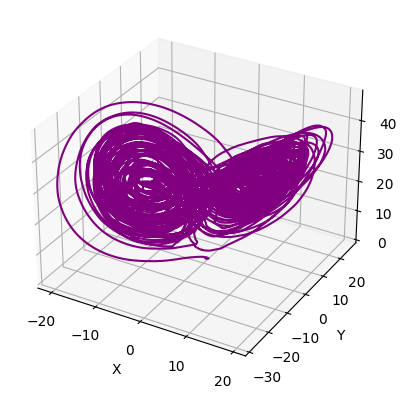

In [25]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x,u[0],u[1], 'purple')
ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.ylabel('Y')
plt.show()

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x,u_hat[0],u_hat[1], 'purple')
ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.ylabel('Y')
plt.show()